# Define some functions

In [1]:
import os
def batch_convert_images_to_binary(start_step, end_step, directory="/content/drive/MyDrive/sherlock_data/grain_size_elle_results/S1.0e-8T-10/results/"):
    """
    Recursively reads a range of PNG images with filenames in the format "stepXXX.png"
    and converts them to binary matrices.

    Args:
    start_step (int): The starting step number.
    end_step (int): The ending step number.
    directory (str): The directory where the PNG images are stored.

    Returns:
    dict: A dictionary where keys are filenames and values are the corresponding binary matrices.
    """
    binary_matrices = {}

    for step in range(start_step, end_step + 1):
        # Construct the filename based on the current step
        filename = f"step{step:03}.png"
        filepath = os.path.join(directory, filename)

        # Check if the file exists
        if os.path.exists(filepath):
            # Convert the image to a binary matrix
            binary_matrix = extract_lines_to_matrix(filepath)
            binary_matrices[filename] = binary_matrix
        else:
            print(f"File {filename} not found.")

    return binary_matrices

import os

def png_to_grayscale_matrix(png_file_path):
    """
    Converts a PNG image file into a grayscale matrix representation.

    Args:
    png_file_path (str): The file path of the PNG image.

    Returns:
    np.ndarray: A grayscale matrix representation of the image.
    """
    # Open the image using PIL
    with Image.open(png_file_path) as img:
        # Convert the image to grayscale
        img_gray = img.convert("L")

        # Convert the image to a NumPy array
        matrix = np.array(img_gray)

    return matrix

def extract_lines_to_matrix(png_file_path, threshold=5):
    """
    Converts a PNG image file into a binary matrix where the lines are marked with 1 and the rest is 0.

    Args:
    png_file_path (str): The file path of the PNG image.
    threshold (int): A threshold value to determine what is considered a line.
                     Pixels lighter than this will be 1, darker will be 0.

    Returns:
    np.ndarray: A binary matrix representation of the lines in the image.
    """
    # Convert the image to a grayscale matrix first
    grayscale_matrix = png_to_grayscale_matrix(png_file_path)

    # Apply threshold to distinguish lines from the background
    binary_matrix = np.where(grayscale_matrix < threshold, 1, 0)

    return binary_matrix

# combine all sample data to the shape of [# of samples, # of time steps, nx, ny]
def dicts_to_4d_array(*dicts):
    """
    Combine an arbitrary number of dictionaries of binary matrices into a 4D NumPy array.

    Args:
    *dicts: An arbitrary number of dictionaries of binary matrices.

    Returns:
    np.ndarray: A 4D NumPy array with the shape [number of dicts, number of snapshots, nx, ny].
    """
    # Initialize a list to hold all matrices from each dictionary
    all_matrices = []

    # Iterate over each dictionary provided as input
    for dict_ in dicts:
        # Extract matrices from the current dictionary and sort them to maintain order
        matrices = [dict_[key] for key in sorted(dict_.keys())]
        # Append the list of matrices from the current dictionary to the overall list
        all_matrices.append(matrices)

    # Convert the list of all matrices into a 4D NumPy array
    array_4d = np.array(all_matrices)

    return array_4d

# Clone codes and model

In [2]:
! git clone https://github.com/EmmaLammE/CS229_FNO.git

Cloning into 'CS229_FNO'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 127 (delta 9), reused 27 (delta 7), pack-reused 93
Receiving objects: 100% (127/127), 52.63 MiB | 18.65 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [3]:
%cd /content/CS229_FNO/
! git branch
! git checkout sherlock

/content/CS229_FNO
* master
Branch 'sherlock' set up to track remote branch 'sherlock' from 'origin'.
Switched to a new branch 'sherlock'


# Train model

This step can be skipped. The trained model is stored under ./model

In [ ]:
%cd /content/CS229_FNO/example/
! python train_grainsize.py --strainrate_path  /content/CS229_FNO/data/strainrate_traindata.npy.npz \
                --temperature_path  /content/CS229_FNO/data/temperature_traindata.npy.npz \
                --grainsize_path  /content/CS229_FNO/data/grainsize_traindata.npy.npz \
                --save_path /content/CS229_FNO/model/model_grainsize_ns50_nt50

/content/CS229_FNO/example
^C


# Test data

In [4]:
import sys
sys.path.append('/content/CS229_FNO/src/')

import torch
import matplotlib.pyplot as plt
from model_grainsize import FNO2d
from plot_tools import plot_data
from PIL import Image
import numpy as np

import numpy as np

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
start_step, end_step = 0,50
frame_width = 1
grainsize_dict_9d0e9 = batch_convert_images_to_binary(start_step, end_step,
                                                          directory="/content/drive/MyDrive/sherlock_data/grain_size_elle_results/S1.0e-9T-10/results/")
# grainsize_dict_9d0e9 = remove_frames_from_all_matrices(grainsize_dict_9d0e9, frame_width)

grainsize_test = dicts_to_4d_array(grainsize_dict_9d0e9)

strainrate_test = np.ones([grainsize_test.shape[0],grainsize_test.shape[2],grainsize_test.shape[3]])
temperature_test = np.ones([grainsize_test.shape[0],grainsize_test.shape[2],grainsize_test.shape[3]])

shearrate = np.array([1.0e-9])
temperature = np.ones(shearrate.shape)*-10
for i in range(grainsize_test.shape[0]):
    strainrate_test[i,:,:] = shearrate[i]
    temperature_test[i,:,:] = temperature[i]

print(strainrate_test.shape)
print(temperature_test.shape)

(1, 450, 450)
(1, 450, 450)


In [12]:
np.savez_compressed(f'/content/CS229_FNO/data/strainrate_testdata.npy', strainrate_test)
np.savez_compressed(f'/content/CS229_FNO/data/temperature_testdata.npy', temperature_test)
np.savez_compressed(f'/content/CS229_FNO/data/grainsize_testdata.npy', grainsize_test)

In [13]:
# Load test dataset
strainrate_path = '/content/CS229_FNO/data/strainrate_testdata.npy.npz'
temperature_path = '/content/CS229_FNO/data/temperature_testdata.npy.npz'
grainsize_path = '/content/CS229_FNO/data/grainsize_testdata.npy.npz'
strainrate = np.load(strainrate_path)
temperature = np.load(temperature_path)
grainsize = np.load(grainsize_path)
strainrate = torch.from_numpy(strainrate['arr_0']).float()
temperature = torch.from_numpy(temperature['arr_0']).float()
grainsize = torch.from_numpy(grainsize['arr_0']).float()

strainrate = strainrate.unsqueeze(-1)
temperature = temperature.unsqueeze(-1)

# permute the dimensions of the output data
grainsize = grainsize.permute(0, 2, 3, 1)

print(strainrate.shape)
print(temperature.shape)
print(grainsize.shape)


# the model parameter should be the same as the training
mode1           = 12
mode2           = 12
width           = 15
T_in = 25
T_end = 50
size_of_grainsize_train_u = T_end-T_in
num_inputparams=2
model = FNO2d(mode1, mode2, width,T_in,size_of_grainsize_train_u,num_inputparams=2)

data_path  = '/content/CS229_FNO/data/'
model_path = '/content/CS229_FNO/model/'

# Load model
model.load_state_dict(torch.load(model_path + 'model_grainsize_ns50_nt25_50'))

torch.Size([1, 450, 450, 1])
torch.Size([1, 450, 450, 1])
torch.Size([1, 450, 450, 51])


<All keys matched successfully>

# Prediction

In [14]:
grainsize_pred = model(grainsize[:,:,:,:T_in], strainrate, temperature)
grainsize_pred = torch.cat((grainsize[:,:,:,:T_in], grainsize_pred), dim=-1)
grainsize_pred = grainsize_pred.detach().numpy()
print(grainsize_pred.shape)

(1, 450, 450, 50)


(-0.5, 449.5, 449.5, -0.5)

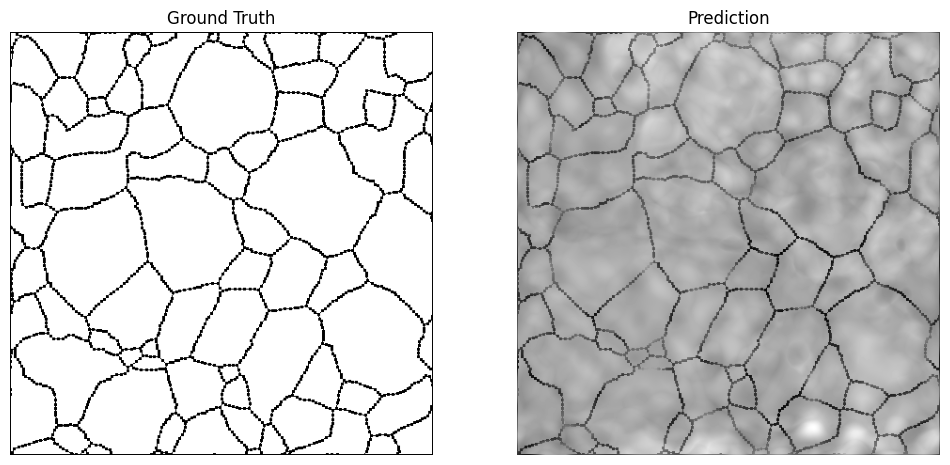

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

timestep_show = 49

axes[0].imshow(grainsize[0,:,:,timestep_show], cmap='gray')
axes[0].set_title(f"Ground Truth")
axes[0].axis('off')

axes[1].imshow(grainsize_pred[0,:,:,timestep_show], cmap='gray')
axes[1].set_title(f"Prediction")
axes[1].axis('off')